# Available Bluebikes Predictor

My hobby project to predict the number of available bluebikes in 3 stations near my home using historical trip data and weather data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import os
from trip_data import get_data

## Extract and Process Data

### Blue Bike Trip Data

Trip data consists of all Bluebike trips from Dec. 2023 to Jan. 2025.

In [3]:
# init data and download trip data csv files

data_path = './trip_data'

# trip data range, currently using 2023 Dec to 2025 Jan
start_year = 2024
end_year = 2025
start_month = 1
end_month = 1
start_date = datetime(start_year, start_month, 1)
end_date = datetime(end_year, end_month, 1)
current_date = start_date

# weather csv filename
weather_csv = f"{start_date.strftime('%Y%m%d')}-{datetime(end_date.year, end_month+1, 1).strftime('%Y%m%d')}-weather-data.csv"

In [108]:
get_data.get_weather_data(start_year, start_month, end_year, end_month+1, data_path)

Downloaded weather data: ./trip_data/20240101-20250201-weather-data.csv


In [6]:
get_data.get_bluebikes_trip_data(start_year,start_month,end_year,end_month,data_path)

https://s3.amazonaws.com/hubway-data/202312-bluebikes-tripdata.zip
Downloading: https://s3.amazonaws.com/hubway-data/202312-bluebikes-tripdata.zip
Downloaded: ./trip_data/202312-bluebikes-tripdata.zip
Extracted: 202312-bluebikes-tripdata.csv to ./trip_data
Deleted zip file: ./trip_data/202312-bluebikes-tripdata.zip
https://s3.amazonaws.com/hubway-data/202401-bluebikes-tripdata.zip
Downloading: https://s3.amazonaws.com/hubway-data/202401-bluebikes-tripdata.zip
Downloaded: ./trip_data/202401-bluebikes-tripdata.zip
Extracted: 202401-bluebikes-tripdata.csv to ./trip_data
Deleted zip file: ./trip_data/202401-bluebikes-tripdata.zip
https://s3.amazonaws.com/hubway-data/202402-bluebikes-tripdata.zip
Downloading: https://s3.amazonaws.com/hubway-data/202402-bluebikes-tripdata.zip
Downloaded: ./trip_data/202402-bluebikes-tripdata.zip
Extracted: 202402-bluebikes-tripdata.csv to ./trip_data
Deleted zip file: ./trip_data/202402-bluebikes-tripdata.zip
https://s3.amazonaws.com/hubway-data/202403-blueb

### Weather Data

In [4]:
weather_df = pd.read_csv(data_path + '/' + weather_csv, skiprows=2)

# rename columns
weather_df = weather_df.rename(columns={
    'temperature_2m (°C)': 'temperature',
    'precipitation (mm)': 'precipitation',
})


# convert time to datetime
weather_df['time'] = pd.to_datetime(weather_df['time'])

# interpolate weather data to 15 min intervals
weather_df_interpolated = weather_df.set_index('time').resample('15min').interpolate(method="nearest")
# round temperature to int
weather_df_interpolated['temperature'] = weather_df_interpolated['temperature'].round(0)


# reset index
weather_df_interpolated = weather_df_interpolated.reset_index()

# drop Feb 1 2025 data
weather_df_interpolated = weather_df_interpolated[weather_df_interpolated['time'].dt.date != datetime(2025, 2, 1).date()]


weather_df_interpolated

,time,temperature,precipitation
0,2024-01-01 00:00:00,-2.0,0.0
1,2024-01-01 00:15:00,-2.0,0.0
2,2024-01-01 00:30:00,-2.0,0.0
3,2024-01-01 00:45:00,-3.0,0.0
4,2024-01-01 01:00:00,-3.0,0.0
...,...,...,...
38107,2025-01-31 22:45:00,1.0,1.0
38108,2025-01-31 23:00:00,1.0,1.0
38109,2025-01-31 23:15:00,1.0,1.0
38110,2025-01-31 23:30:00,1.0,1.0


Quick Visualization of Weather

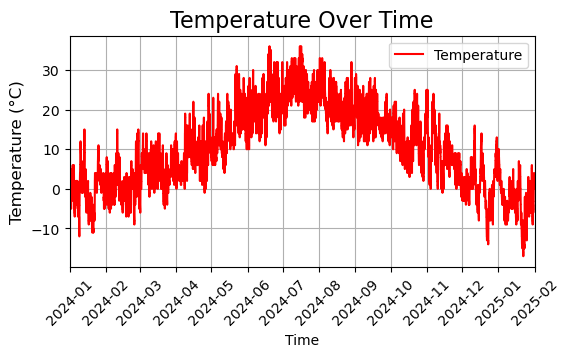

In [4]:
# Plot temperature over time
plt.figure(figsize=(6, 3))
sns.lineplot(x='time', y='temperature', data=weather_df_interpolated, color='red', label='Temperature')
plt.title('Temperature Over Time', fontsize=16)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xticks(rotation=45)
plt.xlim(start_date, datetime(end_year, end_month+1,1))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.legend()
plt.grid(visible=True)
plt.show()

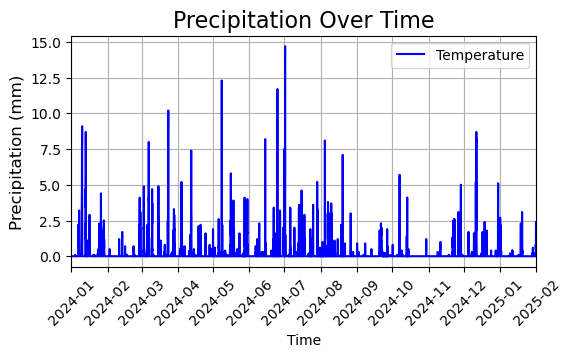

In [5]:
# Plot temperature over time
plt.figure(figsize=(6, 3))
sns.lineplot(x='time', y='precipitation', data=weather_df_interpolated, color='blue', label='Temperature')
plt.title('Precipitation Over Time', fontsize=16)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Precipitation (mm)', fontsize=12)
plt.xticks(rotation=45)
plt.xlim(start_date, datetime(end_year, end_month+1,1))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.legend()
plt.grid(visible=True)
plt.show()

## Filter Trip Data

Load and combine trip CSVs into one dataframe

In [5]:
# combine all trip data into one dataframe
data_frames = []

current_date = start_date

while current_date <= end_date:
    file = f"{current_date.strftime('%Y%m')}-bluebikes-tripdata.csv"
    file_path = os.path.join(data_path, file)
    df = pd.read_csv(file_path)
    data_frames.append(df)

    if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
    else:
        current_date = datetime(current_date.year, current_date.month + 1, 1)

trip_data_df = pd.concat(data_frames, ignore_index=True)

Filter trips to only include stations near my home

In [6]:
# bluebike stations near me
# "A32012" : "Packard's Corner - Commonwealth Ave at Brighton Ave",
# "E32016" : "Commonwealth Ave at Naples Rd",
# "D32035" : "Harvard Ave at Brainerd Rd",
stations_of_interest = ["A32012", "E32016", "D32035"]
stations_docks = {
    "A32012" : 26,
    "E32016" : 19,
    "D32035" : 19
}

# filter trips that start or end at my stations
filtered_trip_data = trip_data_df[trip_data_df['start_station_id'].isin(stations_of_interest) | trip_data_df['end_station_id'].isin(stations_of_interest)].copy()

In [7]:
# remove milliseconds from start and end time
filtered_trip_data.loc[:, 'started_at'] = filtered_trip_data.started_at.str[:16]
filtered_trip_data.loc[:, 'ended_at'] = filtered_trip_data.ended_at.str[:16]

In [8]:
# convert start and end time to datetime
filtered_trip_data['started_at'] = pd.to_datetime(filtered_trip_data.loc[:,'started_at'])
filtered_trip_data['ended_at'] = pd.to_datetime(filtered_trip_data.loc[:,'ended_at'])

# sort by start time
filtered_trip_data.sort_values('started_at', inplace=True)

# remove rideable_type, member_casual columns
filtered_trip_data.drop('rideable_type', axis=1, inplace=True)
filtered_trip_data.drop('member_casual', axis=1, inplace=True)
filtered_trip_data.drop('ride_id', axis=1, inplace=True)


filtered_trip_data.head()

,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng
119455,2024-01-01 00:50:00,2024-01-01 01:17:00,Union Square - Somerville,S32002,Harvard Ave at Brainerd Rd,D32035,42.379648,-71.095405,42.349530,-71.130228
96340,2024-01-01 01:13:00,2024-01-01 01:29:00,Kenmore Square,B32010,Packard's Corner - Commonwealth Ave at Brighto...,A32012,42.348706,-71.097009,42.352261,-71.123831
83237,2024-01-01 01:14:00,2024-01-01 01:21:00,Old Morse Park at Putnam Ave,M32076,Packard's Corner - Commonwealth Ave at Brighto...,A32012,42.357662,-71.108413,42.352261,-71.123831
47908,2024-01-01 01:16:00,2024-01-01 01:24:00,Commonwealth Ave at Naples Rd,E32016,MIT Vassar St,M32042,42.351911,-71.123798,42.355601,-71.103945
16161,2024-01-01 01:22:00,2024-01-01 01:25:00,Commonwealth Ave at Kelton St,D32034,Harvard Ave at Brainerd Rd,D32035,42.348359,-71.139972,42.349530,-71.130228


## Aggregate Data

My approach is to calculate the departures and arrivals for each station in 15 minute intervals.

### Initialize Dataframe with Time Intervals and Temporal Features

In [72]:
# init variables
time_interval = '15min'
station_ids = ['A32012', 'E32016', 'D32035']

# create df w/ 15 min intervals
start_time = datetime(2024, 1, 1, 0, 0)
end_time = datetime(2025, 1, 31, 23, 45)
time_range = pd.date_range(start=start_time, end=end_time, freq=time_interval)

base_df = pd.DataFrame([(time, station) for time in time_range for station in station_ids],
                       columns=["time", "station_id"])

# temporal features
base_df["hour"] = base_df["time"].dt.hour
base_df["minute"] = base_df["time"].dt.minute
base_df["day_of_week"] = base_df["time"].dt.dayofweek  # Mon=0, Tues=1,...,Sun=6
base_df["month"] = base_df["time"].dt.month

base_df.head(9)

,time,station_id,hour,minute,day_of_week,month
0,2024-01-01 00:00:00,A32012,0,0,0,1
1,2024-01-01 00:00:00,E32016,0,0,0,1
2,2024-01-01 00:00:00,D32035,0,0,0,1
3,2024-01-01 00:15:00,A32012,0,15,0,1
4,2024-01-01 00:15:00,E32016,0,15,0,1
5,2024-01-01 00:15:00,D32035,0,15,0,1
6,2024-01-01 00:30:00,A32012,0,30,0,1
7,2024-01-01 00:30:00,E32016,0,30,0,1
8,2024-01-01 00:30:00,D32035,0,30,0,1


### Calculate departures and arrivals

For each station, I will calculate the number of departures and arrivals in every 15 minute interval.

In [68]:
# Round trip times to the nearest interval
filtered_trip_data["start_interval"] = filtered_trip_data["started_at"].dt.floor(time_interval)
filtered_trip_data["end_interval"] = filtered_trip_data["ended_at"].dt.floor(time_interval)

# Filter for the specified station IDs
stations_of_interest = ["A32012", "E32016", "D32035"]
filtered_departures = filtered_trip_data[filtered_trip_data["start_station_id"].isin(stations_of_interest)]
filtered_arrivals = filtered_trip_data[filtered_trip_data["end_station_id"].isin(stations_of_interest)]

# Count departures and arrivals for each station and 15-minute interval
departures = (
    filtered_departures.groupby(["start_interval", "start_station_id"])
    .size()
    .reset_index(name="departures")
    .rename(columns={"start_interval": "time", "start_station_id": "station_id"})
)

arrivals = (
    filtered_arrivals.groupby(["end_interval", "end_station_id"])
    .size()
    .reset_index(name="arrivals")
    .rename(columns={"end_interval": "time", "end_station_id": "station_id"})
)

### Merge data

Merging departures, arrivals, temperature, precipitation, and temporal data

In [73]:
# Merge departures and arrivals with the base DataFrame
base_df = base_df.merge(departures, on=["time", "station_id"], how="left")
base_df = base_df.merge(arrivals, on=["time", "station_id"], how="left")

# Fill missing values with 0
base_df["departures"] = base_df["departures"].fillna(0).astype(int)
base_df["arrivals"] = base_df["arrivals"].fillna(0).astype(int)

# merge weather data with base_df
base_df = base_df.merge(weather_df_interpolated, on="time", how="left")

# create a total trips column
base_df['total_trips'] = base_df['departures'] + base_df['arrivals']

In [76]:
print(base_df.isnull().sum())

base_df.tail(6)

time             0
station_id       0
hour             0
minute           0
day_of_week      0
month            0
departures       0
arrivals         0
temperature      0
precipitation    0
total_trips      0
dtype: int64


,time,station_id,hour,minute,day_of_week,month,departures,arrivals,temperature,precipitation,total_trips
114330,2025-01-31 23:30:00,A32012,23,30,4,1,0,0,1.0,1.0,0
114331,2025-01-31 23:30:00,E32016,23,30,4,1,0,0,1.0,1.0,0
114332,2025-01-31 23:30:00,D32035,23,30,4,1,1,1,1.0,1.0,2
114333,2025-01-31 23:45:00,A32012,23,45,4,1,0,0,0.0,0.8,0
114334,2025-01-31 23:45:00,E32016,23,45,4,1,0,0,0.0,0.8,0
114335,2025-01-31 23:45:00,D32035,23,45,4,1,0,0,0.0,0.8,0


## Data Analysis

Below I will do some basic trip data inspection where I will looking through data like weather vs trip data, hour of the day vs day of week heatmap, etc.

### Analyzing Monthly Trips Pattern

As expected, most bike usage occurs in warmer seasons

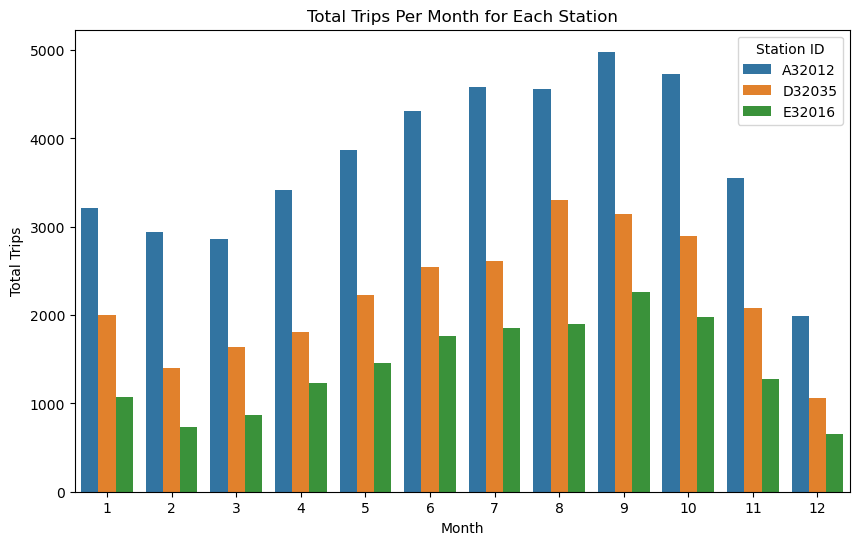

In [77]:
# Group by month and station
monthly_trips = base_df.groupby(["month", "station_id"])["total_trips"].sum().reset_index()

# Plot total trips per month for each station
plt.figure(figsize=(10, 6))
sns.barplot(data=monthly_trips, x="month", y="total_trips", hue="station_id")
plt.title("Total Trips Per Month for Each Station")
plt.xlabel("Month")
plt.ylabel("Total Trips")
plt.legend(title="Station ID")
plt.show()


### Anaylzing Popular Days of the Week for Trips

Not too much variance between different days of the week

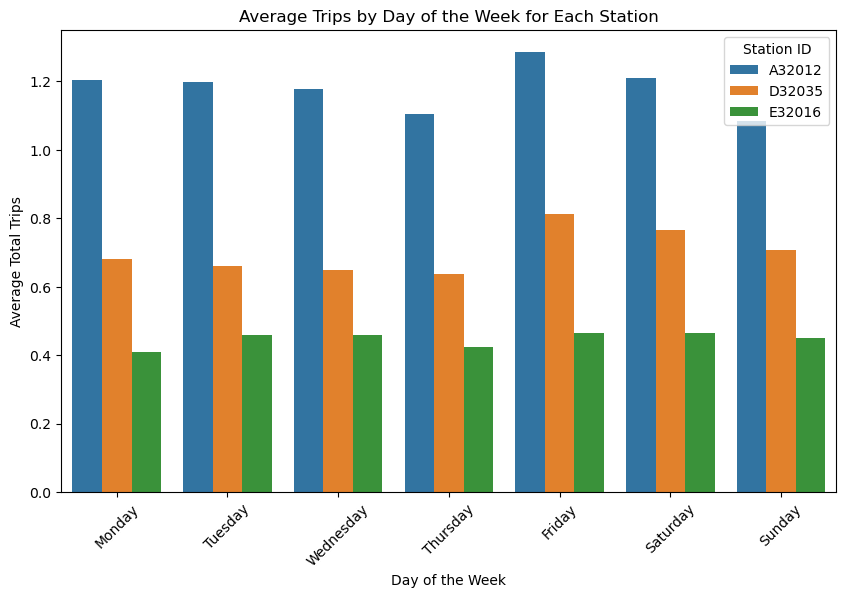

In [78]:
# Group by day of the week and station
weekday_trips = base_df.groupby(["day_of_week", "station_id"])["total_trips"].mean().reset_index()

# Map day_of_week to names for better readability
weekday_mapping = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
weekday_trips["day_of_week"] = weekday_trips["day_of_week"].map(weekday_mapping)

# Plot average trips by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(data=weekday_trips, x="day_of_week", y="total_trips", hue="station_id")
plt.title("Average Trips by Day of the Week for Each Station")
plt.xlabel("Day of the Week")
plt.ylabel("Average Total Trips")
plt.legend(title="Station ID")
plt.xticks(rotation=45)
plt.show()

### Analyzing Popular Hours of the Day for Trips

Seems like most trips occur between 9 am and 8 pm, with most usage being around 5 pm.

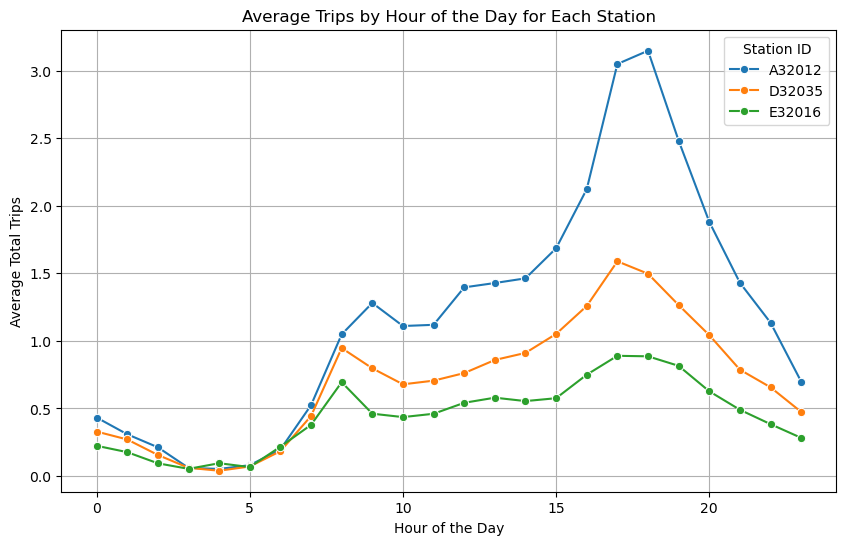

In [82]:
# Group by hour of the day and station
hourly_trips = base_df.groupby(["hour", "station_id"])["total_trips"].mean().reset_index()

# Plot average trips by hour of the day
plt.figure(figsize=(10, 6))
sns.lineplot(data=hourly_trips, x="hour", y="total_trips", hue="station_id", marker="o")
plt.title("Average Trips by Hour of the Day for Each Station")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Total Trips")
plt.legend(title="Station ID")
plt.grid()
plt.show()

### Analyzing Temperature vs Total Trips Relationship

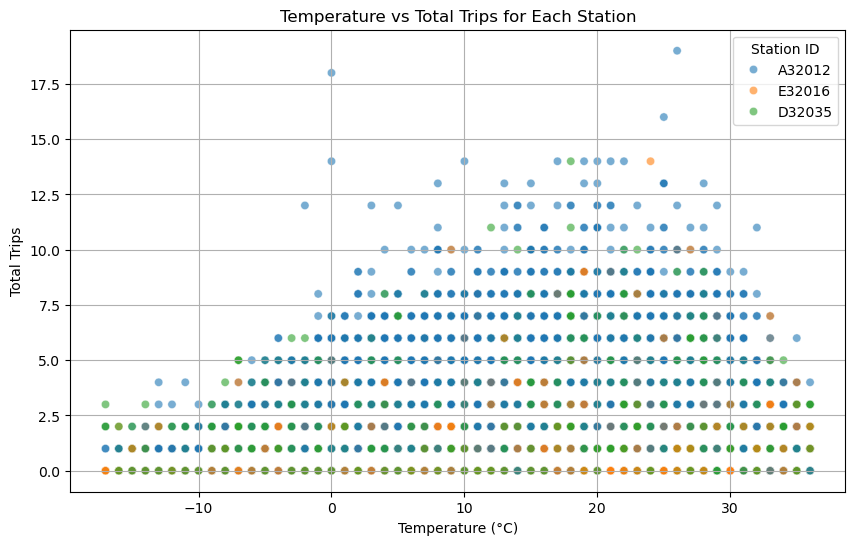

In [79]:
# Plot temperature vs total trips for each station
plt.figure(figsize=(10, 6))
sns.scatterplot(data=base_df, x="temperature", y="total_trips", hue="station_id", alpha=0.6)
plt.title("Temperature vs Total Trips for Each Station")
plt.xlabel("Temperature (°C)")
plt.ylabel("Total Trips")
plt.legend(title="Station ID")
plt.grid()
plt.show()

### Analyzing Precipitation vs Total Trips Relationship

As expected, there are generally more trips with lower precipitation.

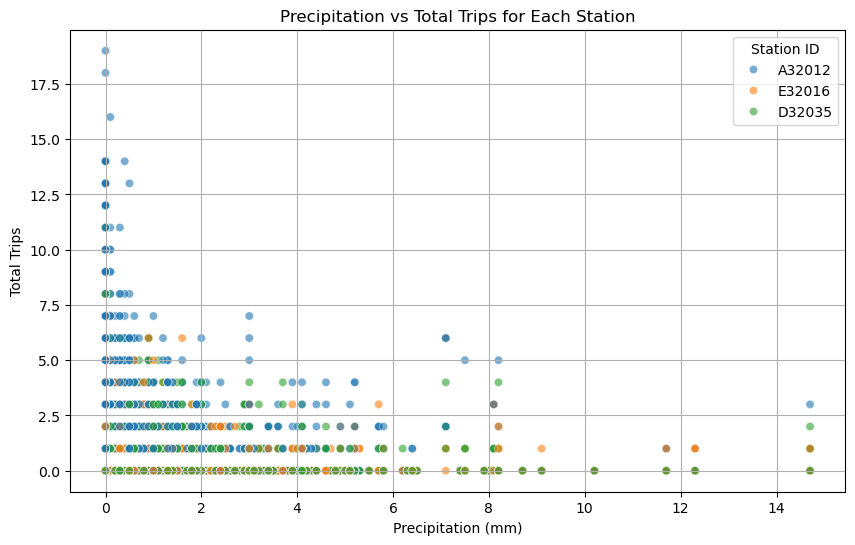

In [80]:
# Plot precipitation vs total trips for each station
plt.figure(figsize=(10, 6))
sns.scatterplot(data=base_df, x="precipitation", y="total_trips", hue="station_id", alpha=0.6)
plt.title("Precipitation vs Total Trips for Each Station")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Total Trips")
plt.legend(title="Station ID")
plt.grid()
plt.show()

## Prediction Models

### Adding Lag Features

Since this is a time-series forecasting problem where previous bike activities can influence recent/future activity, lag features are added to capture this relationship.

In [90]:
# Add lag features for departures and arrivals
for lag in [1, 2, 3]:  # Lag intervals (15, 30, 45 minutes)
    base_df[f"departures_lag_{lag}"] = base_df.groupby("station_id")["departures"].shift(lag)
    base_df[f"arrivals_lag_{lag}"] = base_df.groupby("station_id")["arrivals"].shift(lag)

# Fill missing lag values with 0 (or use other imputation strategies)
base_df.fillna(0, inplace=True)

In [94]:
base_df.iloc[201:210]

,time,station_id,hour,minute,day_of_week,month,departures,arrivals,temperature,precipitation,total_trips,departures_lag_1,arrivals_lag_1,departures_lag_2,arrivals_lag_2,departures_lag_3,arrivals_lag_3
201,2024-01-01 16:45:00,A32012,16,45,0,1,0,2,-0.0,0.0,2,1.0,1.0,0.0,0.0,0.0,0.0
202,2024-01-01 16:45:00,E32016,16,45,0,1,0,0,-0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0
203,2024-01-01 16:45:00,D32035,16,45,0,1,0,0,-0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
204,2024-01-01 17:00:00,A32012,17,0,0,1,0,0,-0.0,0.0,0,0.0,2.0,1.0,1.0,0.0,0.0
205,2024-01-01 17:00:00,E32016,17,0,0,1,0,0,-0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0
206,2024-01-01 17:00:00,D32035,17,0,0,1,0,0,-0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
207,2024-01-01 17:15:00,A32012,17,15,0,1,0,2,-0.0,0.0,2,0.0,0.0,0.0,2.0,1.0,1.0
208,2024-01-01 17:15:00,E32016,17,15,0,1,0,0,-0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
209,2024-01-01 17:15:00,D32035,17,15,0,1,0,0,-0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
